In [48]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import *
import umap
import os
from sknetwork.clustering import Louvain,get_modularity
# import umap.plot


In [90]:
def return_name_string_obj_NC(data):
  broken_str = data.split('_')
  if 'NC' == broken_str[2]:
    name = broken_str[2]
    date = broken_str[3]
    return name+'_'+date
  else:
    name = broken_str[3]
    date = broken_str[2]
    return name+'_'+date

def modify_names(file_name):
  str_temp = file_name
  all_parts = str_temp.split('_')
  print(all_parts)
  name = all_parts[0]
  if 'Payam' == name:
    name = name.lower()
  broken = all_parts[1].split('-')
  date = broken[:3]
  date = date[0]+date[1]+date[2]
  exp = broken[3]
  return name+'_'+date+'_'+exp

def return_name_date_exp_fn(string):

  if 'NC' in string:
    string_broken = string.split('_')
    name = string_broken[0]
    date = string_broken[1]
    exp = string_broken[-1]
    year = date[:2]
    month = date[2:4]

    if month[0] =='0':
      month = month[1]
    day = date[4:]
    if day[0] =='0':
      day = day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp 
  elif 'xuan' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1].replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp
  elif 'asli' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1]
    date = date.replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp    
  elif 'Payam' in string:
    broken_str = string.split('_')
    name = broken_str[0].lower()
    date = broken_str[1].split('-')
    exp =  broken_str[2]
    day = date[0]
    month = date[1]
    year = date[2]
    if day[0] =='0':
      day=day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp

def plot_UMAP_values(data_inh, values,neighbours=20, distance=0.1, random_state=42,annotate=False,norm=True, c_list=None ,save=False):
    """plots UMAP for excitatory and inhibitory cells

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    if norm:
        data_umap = normalize(data_umap)

    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)

    fig = plt.figure(figsize=[4,4])
    ax12d = fig.add_subplot(1,1,1)

    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d[:, 0],
             'UMAP2':clusterable_embedding2d[:, 1]}

    ax12d.set_xticks([])
    ax12d.set_yticks([])

    ax_ = ax12d.scatter(data=df_2d_exc,x='UMAP1',y='UMAP2',c=values)
    plt.colorbar(ax_)
    if annotate:
        for i in range(len(clusterable_embedding2d)):

            plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))

        # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

        # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
        ax12d.legend()
    if save:
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)

    plt.show()

def plot_UMAP_clusters_single(data_inh, neighbours, distance, res_louvain, random_state,annotate=False,norm=True, c_list=None ,save=False):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    if norm:
        data_umap = normalize(data_umap)
    
    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)
    
    fig = plt.figure(figsize=[8,8])
    ax12d = fig.add_subplot(1,1,1)
    
    louvain = Louvain(resolution=res_louvain,random_state=random_state)
    adjacency = mapper.graph_
    labels_exc = louvain.fit_predict(adjacency)

    print(len(set(labels_exc)))
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d[:, 0],
             'UMAP2':clusterable_embedding2d[:, 1],
             'class':labels_exc}

    ax12d.set_xticks([])
    ax12d.set_yticks([])

    sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
    if annotate:
        for i in range(len(clusterable_embedding2d)):

            plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))

        # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

        # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
        ax12d.legend()
    if save:
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)
    
    plt.show()

    return labels_exc,mapper,reducer

In [56]:
CC_data = pd.read_pickle("D:/CC_analyzed_feat_set/CC_files_all_experimenters_all_conditions.p")
CC_exps = list(set(CC_data['exp_name']))
CC_exps_acsf = CC_data[CC_data.drug==False].exp_name 

In [57]:
FN_data = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_re.pkl")
# FN_data.exp_name = FN_data.exp_name.apply(return_name_date_exp_fn)
FN_data.cond = [i.lower() for i in FN_data.cond]
FN_data_acsf = FN_data[FN_data.cond=='acsf'] 
FN_exps = set(FN_data.exp_name) 
FN_exps_acsf = set(FN_data[FN_data.cond=='acsf'].exp_name) 


In [58]:
common_exps = (list(set(CC_exps_acsf) & set(FN_exps_acsf)))
len(common_exps)

101

In [76]:
common_FN = FN_data[FN_data.exp_name.isin(common_exps)]
common_CC = CC_data[CC_data.exp_name.isin(common_exps)]
CC_acsf = common_CC[common_CC.drug==False].drop_duplicates('exp_name')
FN_acsf = common_FN[common_FN.cond=='acsf'].drop_duplicates('exp_name')

cc_cols = ['waveforms' ,'current_first_spike', 'ap_count', 'abs_firing_rate',
'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
'min_isi', 'median_isi', 'mean_thrs', 'max_thrs',
'min_thrs', 'median_thrs', 'mean_hwidths',
'median_hwidths', 'max_hwidths', 'min_hwidths', 'first_amp', 'mean_amp',
'median_amp', 'max_amp', 'min_amp', 'cond', 'drug', 'exp_name',
'trialnr']


cc_cols_to_scale = ['mean_thrs', 'max_thrs', 'min_thrs', 'median_thrs','mean_amp',
'median_amp', 'max_amp', 'min_amp'] 
CC_acsf[cc_cols_to_scale] = CC_acsf[cc_cols_to_scale]*1000
FN_acsf = FN_acsf.sort_values('exp_name')
CC_acsf = CC_acsf.sort_values('exp_name')
CC_acsf = CC_acsf[cc_cols]
CC_acsf.columns = ['waveform','current_at_first_spike', 'ap_count', 'fr',
       'inst_fr', 'time_to_first_spike', 'mean_isi', 'max_isi',
       'min_isi', 'median_isi', 'mean_thr', 'max_thr', 'min_thr',
       'median_thr', 'mean_width', 'median_width', 'max_width',
       'min_width', 'first_amplitude', 'mean_amplitude', 'median_amplitude', 'max_amplitude',
       'min_amplitude', 'cond', 'drug', 'exp_name', 'trialnr']

In [79]:
FN_acsf.columns

Index(['waveform', 'current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',
       'tau', 'exp_name', 'cond', 'trialnr'],
      dtype='object')

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


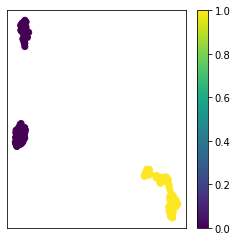

In [91]:
fn_numpy = FN_acsf[FN_acsf.columns[1:-4]].to_numpy()
cc_numpy = CC_acsf[CC_acsf.columns[1:-4]].to_numpy()
all = np.vstack([fn_numpy,cc_numpy]) 
plot_UMAP_values(all,np.hstack([np.ones(len(fn_numpy)),np.zeros(len(cc_numpy))]),random_state=42)

# lables_wave_fn,mapper,reducer = plot_UMAP_clusters_single(all,
#                           20,
#                           0.1,
#                           random_state =42,
#                           res_louvain = .1,
#                           c_list =coherence_colors,)

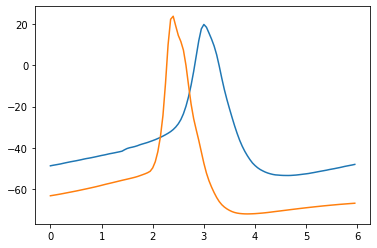

In [16]:
plt.plot(np.arange(0,120/20,1/20),np.array(CC_acsf[CC_acsf.exp_name== common_exps[1]]['waveforms'])[0]*1000)
plt.plot(np.arange(0,120/20,1/20),np.array(FN_acsf[FN_acsf.exp_name== common_exps[1]]['waveform'])[0][2*20:-20])

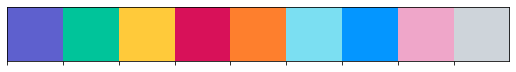

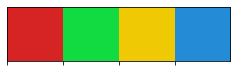

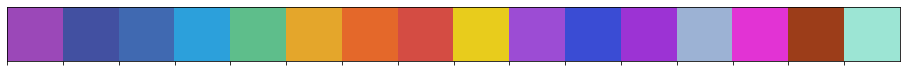

In [17]:
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
                    [0.259,	0.314, 0.635],
                    [0.251,	0.412, 0.698],
                    [0.176,	0.631, 0.859],
                    [0.369,	0.749, 0.549],
                    [0.898,	0.654, 0.169],
                    [0.898,	0.41 , 0.165],
                    [0.834,	0.3 , 0.265],
                    [0.912,	0.8 , 0.112],
                    [0.612,	0.3 , 0.834],
                    [0.23,	0.3 , 0.834],
                    [0.612,	0.2 , 0.834],
                    [0.612,	0.7 , 0.834],
                    [0.89,	0.2 , 0.834],
                    [0.612,	0.24 , 0.1],
                    [0.612,	0.9 , 0.834]]

sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


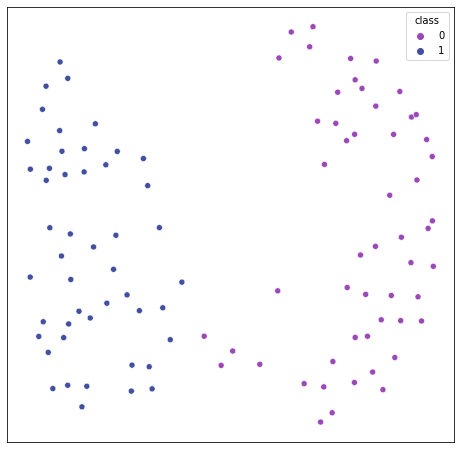

In [18]:
waves = normalize(np.vstack(FN_acsf['waveform']))
lables_wave_fn,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.3,
                          random_state =42,
                          res_louvain = .1,
                          c_list =coherence_colors,)

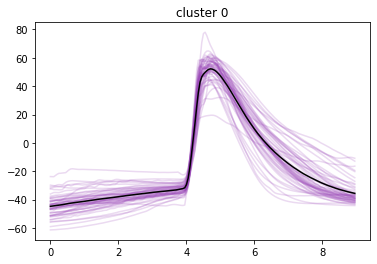

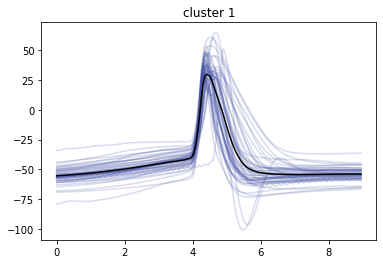

In [24]:
FN_acsf['LV_ID'] = lables_wave_cc
# ephys['wave_ID']
for i in range(len(set(lables_wave_fn))):
    fig = plt.Figure(figsize=[5,5])
    to_plot = np.vstack(FN_acsf[FN_acsf.LV_ID==i]['waveform']).T
    plt.plot(np.arange(0,180/20,1/20),to_plot,c=coherence_colors[i],alpha=0.2)
    plt.title('cluster '+str(i))
    plt.plot(np.arange(0,180/20,1/20), np.mean(np.vstack(FN_acsf[FN_acsf.LV_ID==i]['waveform']).T,axis=1),c='black',alpha=1)
    plt.show()


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


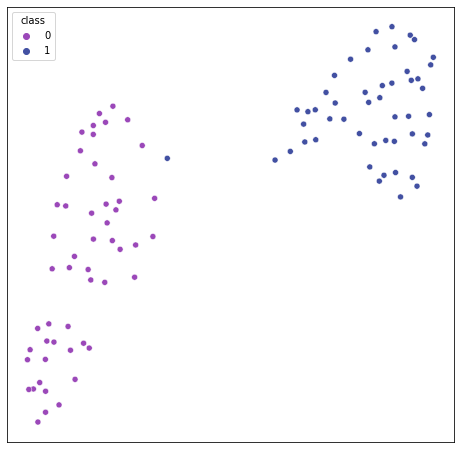

In [22]:
waves = normalize(np.vstack(CC_acsf['waveforms']))
lables_wave_cc,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.3,
                          random_state =42,
                          res_louvain = .1,
                          c_list =coherence_colors,)

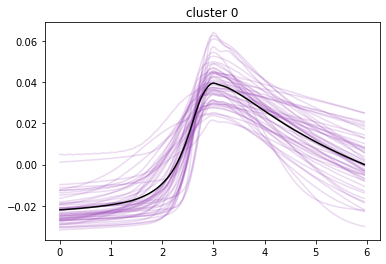

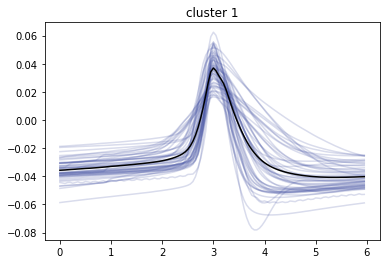

In [23]:
CC_acsf['LV_ID'] = lables_wave_cc

# ephys['wave_ID']
for i in range(len(set(lables_wave_cc))):
    fig = plt.Figure(figsize=[5,5])
    to_plot = np.vstack(CC_acsf[CC_acsf.LV_ID==i]['waveforms']).T
    plt.plot(np.arange(0,120/20,1/20),to_plot,c=coherence_colors[i],alpha=0.2)
    plt.title('cluster '+str(i))
    plt.plot(np.arange(0,120/20,1/20),np.mean(np.vstack(CC_acsf[CC_acsf.LV_ID==i]['waveforms']).T,axis=1),c='black',alpha=1)
    plt.show()


In [25]:
FN_EXC = FN_acsf[FN_acsf.LV_ID==0]
FN_INH = FN_acsf[FN_acsf.LV_ID==1]

CC_EXC = CC_acsf[CC_acsf.LV_ID==0]
CC_INH = CC_acsf[CC_acsf.LV_ID==1]


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


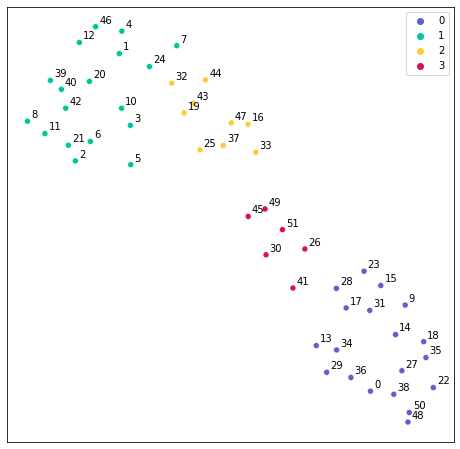

<ipython-input-30-20dee1e0d9d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FN_EXC['lables_lv'] = lables_fn_exc


In [30]:
lables_fn_exc,mapper,reducer = plot_UMAP_clusters_single(FN_EXC[FN_EXC.columns[1:-6]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=True,
                        #   save=True,
                        #   savepath='D:/exc_FN.png'
                          )
FN_EXC['lables_lv'] = lables_fn_exc

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


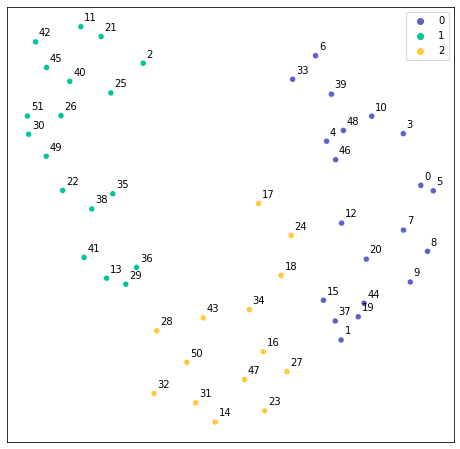

<ipython-input-42-0868b3ceda9a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CC_EXC['lables_lv'] = lables_cc_exc


In [42]:
lables_cc_exc,mapper,reducer = plot_UMAP_clusters_single(CC_EXC[CC_EXC.columns[1:-6]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=True,
                        #   save=True,
                        #   savepath='D:/exc_CC.png'
                          )
CC_EXC['lables_lv'] = lables_cc_exc


Text(33.0, 0.5, 'CC')

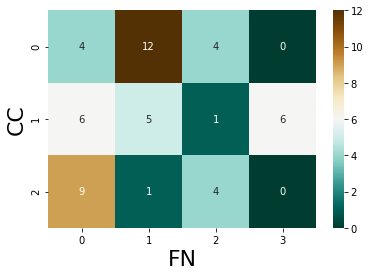

In [43]:

df = pd.DataFrame(columns=['exp_name','labels_CC','labels_FN'])
df['exp_name'] = CC_EXC.exp_name

df['labels_CC'] = np.array(CC_EXC.lables_lv)
df['labels_FN'] = np.array(FN_EXC.lables_lv)

sta_mat = np.zeros((len(set(df['labels_CC'])),len(set(df['labels_FN']))))
for i in np.unique(df.labels_CC):
    data_ = np.unique(df[df.labels_CC==i]['labels_FN'],return_counts=True)
    sta_mat[i,data_[0]] =data_[1] 
sns.heatmap(sta_mat,cmap='BrBG_r',annot=True)   
plt.xlabel('FN',fontsize=22)
plt.ylabel('CC',fontsize=22)
# plt.savefig('D:/exc_correspondence.png',dpi=200,bbox_inches = "tight")


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


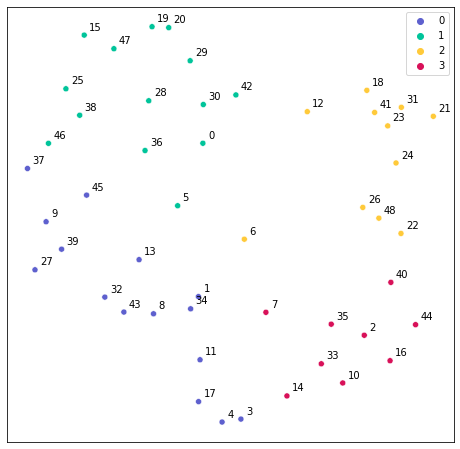

<ipython-input-46-8414e6905698>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FN_INH['lables_lv'] = lables_fn_inh
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


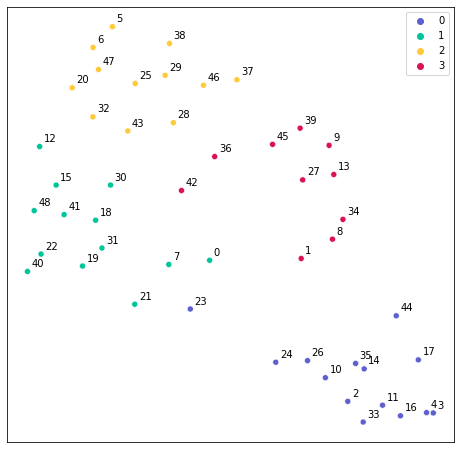

<ipython-input-46-8414e6905698>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CC_INH['lables_lv'] = lables_cc_inh


In [46]:
lables_fn_inh,mapper,reducer = plot_UMAP_clusters_single(FN_INH[FN_INH.columns[1:-6]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=True,
                        #   save=True,
                        #   savepath='D:/inh_FN.png'
                          ) 
FN_INH['lables_lv'] = lables_fn_inh

lables_cc_inh,mapper,reducer = plot_UMAP_clusters_single(CC_INH[CC_INH.columns[1:-6]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=True,
                        #   save=True,
                        #   savepath='D:/inh_CC.png'
                          )
CC_INH['lables_lv'] = lables_cc_inh

Text(33.0, 0.5, 'CC')

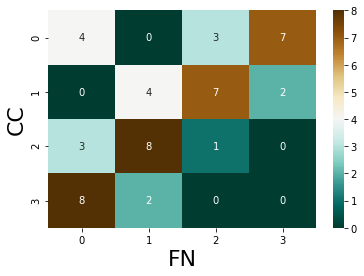

In [47]:

df = pd.DataFrame(columns=['exp_name','labels_CC','labels_FN'])
df['exp_name'] = CC_INH.exp_name

df['labels_CC'] = np.array(CC_INH.lables_lv)
df['labels_FN'] = np.array(FN_INH.lables_lv)

sta_mat = np.zeros((len(set(df['labels_CC'])),len(set(df['labels_FN']))))
for i in np.unique(df.labels_CC):
    data_ = np.unique(df[df.labels_CC==i]['labels_FN'],return_counts=True)
    sta_mat[i,data_[0]] =data_[1] 
sns.heatmap(sta_mat,cmap='BrBG_r',annot=True)   
plt.xlabel('FN',fontsize=22)
plt.ylabel('CC',fontsize=22)
# plt.savefig('D:/exc_correspondence.png',dpi=200,bbox_inches = "tight")


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


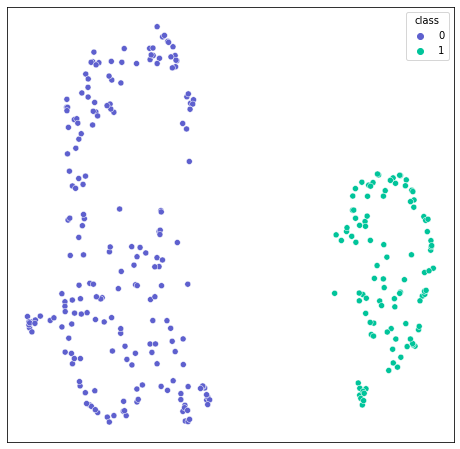

In [37]:
FN_data_acsf = FN_data_acsf.drop_duplicates('exp_name')

waves = normalize(np.vstack(FN_data_acsf['waveform']))

lables_fn_all,mapper,reducer = plot_UMAP_clusters_single(waves,
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = .1,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=False,
                        #   save=True,
                        #   savepath='D:/inh_FN.png'
                          )
# FN_INH['lables_lv'] = lables_fn_inh


306


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


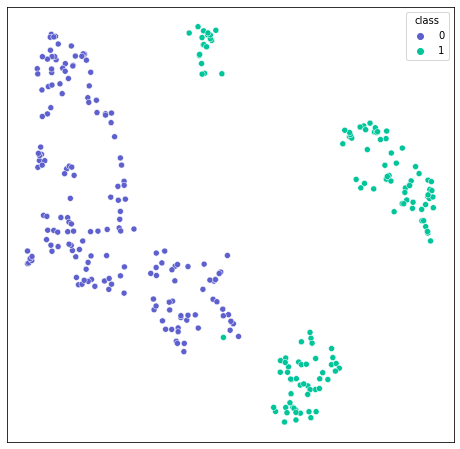

In [33]:
FN_data_acsf = FN_data_acsf.drop_duplicates('exp_name')
print(len(FN_data_acsf))
# all_vals = normalize(np.vstack(FN_data_acsf[FN_data_acsf.columns[1:-5]]))

lables_fn_all,mapper,reducer = plot_UMAP_clusters_single(FN_data_acsf[FN_data_acsf.columns[1:-5]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = .1,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=False,
                        #   save=True,
                        #   savepath='D:/inh_FN.png'
                          )
# FN_INH['lables_lv'] = lables_fn_inh


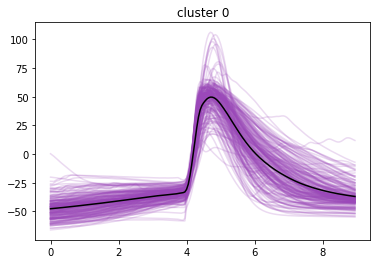

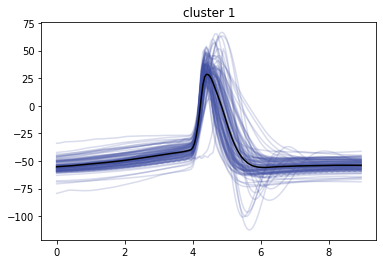

In [40]:
FN_data_acsf['LV_ID'] = lables_fn_all

# ephys['wave_ID']
for i in range(len(set(lables_wave_cc))):
    fig = plt.Figure(figsize=[5,5])
    to_plot = np.vstack(FN_data_acsf[FN_data_acsf.LV_ID==i]['waveform']).T
    plt.plot(np.arange(0,180/20,1/20),to_plot,c=coherence_colors[i],alpha=0.2)
    plt.title('cluster '+str(i))
    plt.plot(np.arange(0,180/20,1/20),np.mean(np.vstack(FN_data_acsf[FN_data_acsf.LV_ID==i]['waveform']).T,axis=1),c='black',alpha=1)
    plt.show()


In [43]:
FN_EXC_ALL = FN_data_acsf[FN_data_acsf.LV_ID==0]
FN_INH_ALL = FN_data_acsf[FN_data_acsf.LV_ID==1]



c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


8


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


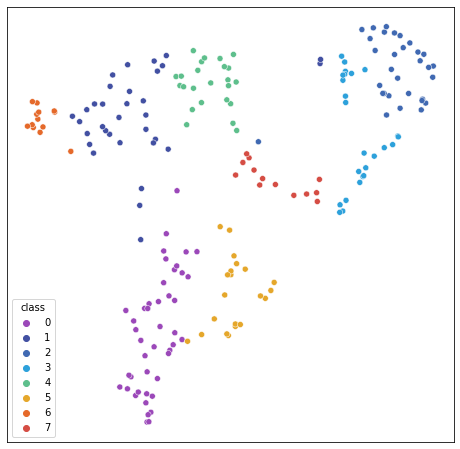

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


7


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


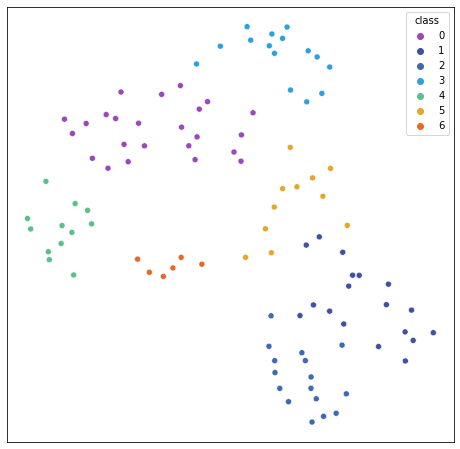

In [42]:
FN_EXC_ALL = FN_EXC_ALL.dropna()
lables_fn_all_exc,mapper,reducer = plot_UMAP_clusters_single(FN_EXC_ALL[FN_EXC_ALL.columns[1:-5]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1,
                          c_list = coherence_colors,
                          annotate=False,
                        #   save=True,
                        #   savepath='D:/inh_FN.png'
                          )


lables_fn_all_inh,mapper,reducer = plot_UMAP_clusters_single(FN_INH_ALL[FN_INH_ALL.columns[1:-5]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1,
                          c_list = coherence_colors,
                          annotate=False,
                        #   save=True,
                        #   savepath='D:/inh_FN.png'
                          )



In [84]:
def plot_UMAP_values(embedding, values, random_state,figsize=[4,4],annotate=False,norm=True, c_list=None ,save=False):
    """plots UMAP for excitatory and inhibitory cells

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """


    fig,ax=plt.subplots(figsize=figsize)
    df_2d_exc = {'UMAP1':embedding[:, 0],
             'UMAP2':embedding[:, 1]}

    ax.set_xticks([])
    ax.set_yticks([])

    ax_ = ax.scatter(data=df_2d_exc,x='UMAP1',y='UMAP2',c=values)
    plt.colorbar(ax_)
    if annotate:
        for i in range(len(embedding)):

            plt.annotate(str(i),(embedding[i,0]+0.05,embedding[i,1]+0.05))

        # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax)

        # ax.set_title('UMAP clusters for excitatory neurons 2D')
        ax.legend()
    if save:
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)

    plt.show()

In [62]:
first_half = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_first.pkl")
first_half_acsf  = first_half[first_half.cond=='acsf']
first_half_acsf = first_half_acsf.drop_duplicates('exp_name')
first_half_acsf = first_half_acsf.dropna()

second_half = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_second.pkl")
second_half_acsf  = second_half[second_half.cond=='acsf']
second_half_acsf = second_half_acsf.drop_duplicates('exp_name')
second_half_acsf = second_half_acsf.dropna()
second_half_acsf = second_half_acsf[second_half_acsf.exp_name.isin(first_half_acsf.exp_name)] 


304 304


In [166]:
corr[corr>0.7].keys()

Index(['ap_count', 'fr', 'inst_fr', 'mean_isi', 'median_isi', 'max_isi',
       'min_isi', 'mean_thr', 'median_thr', 'min_thr', 'max_thr', 'mean_width',
       'median_width', 'max_width', 'min_width', 'mean_amplitude',
       'median_amplitude', 'min_amplitude'],
      dtype='object')

In [177]:
corr = first_half_acsf[first_half_acsf.columns[1:-4]].corrwith(second_half_acsf[first_half_acsf.columns[1:-4]])
# corr[corr>0.9]
# print(corr)


print(corr[corr>0.8])
cols_corr = corr[corr<0.8].keys()
cols_corr

ap_count            0.988584
fr                  0.988613
inst_fr             0.938598
mean_isi            0.870663
max_isi             0.839524
min_isi             0.913427
mean_thr            0.934479
median_thr          0.886902
max_thr             0.816439
mean_width          0.990114
median_width        0.986791
max_width           0.944737
min_width           0.875096
mean_amplitude      0.951999
median_amplitude    0.897681
dtype: object


In [63]:
all_together.columns[1:-4]

Index(['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude'],
      dtype='object')

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


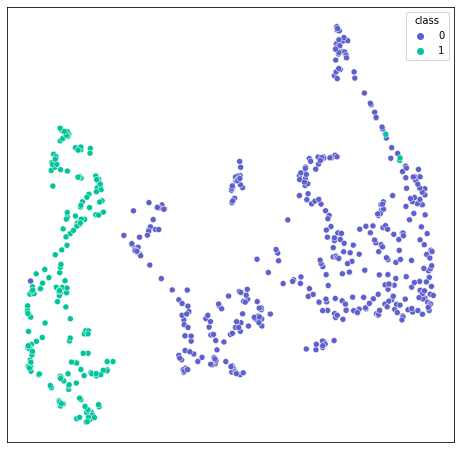

In [173]:
all_together = pd.concat([first_half_acsf,second_half_acsf])
all_together['part'] = np.hstack([np.zeros(len(first_half_acsf)),np.ones(len(second_half_acsf))])
lables_fn_all,mapper,reducer = plot_UMAP_clusters_single(all_together[cols_corr],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = .1,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=False,
                        #   save=True,
                        #   savepath='D:/inh_FN.png'
                          )

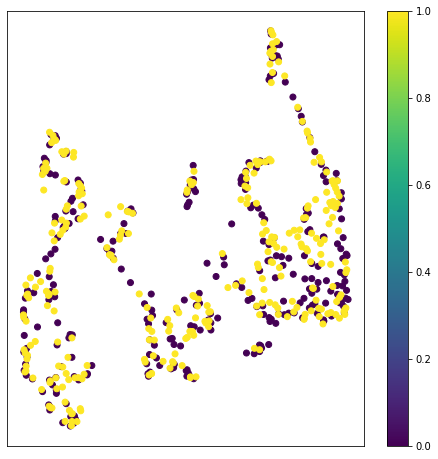

In [178]:
plot_UMAP_values(mapper.embedding_,np.hstack([np.zeros(len(first_half_acsf)),np.ones(len(second_half_acsf))]),random_state=42,figsize=[8,8])

current_at_first_spike
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:2.421e-08 t=-5.730e+00


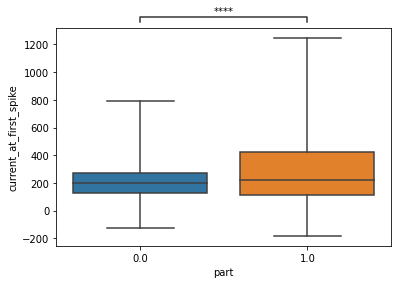

ap_count
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:8.313e-07 t=-5.033e+00


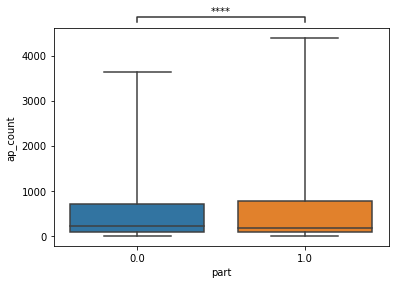

fr
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:7.512e-07 t=-5.054e+00


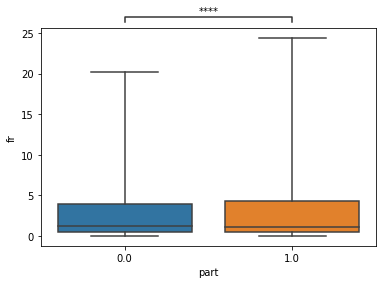

inst_fr
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:2.314e-12 t=7.315e+00


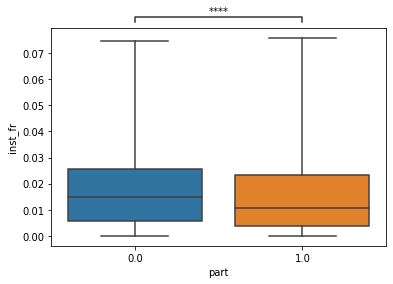

time_to_first_spike
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:2.812e-02 t=2.206e+00


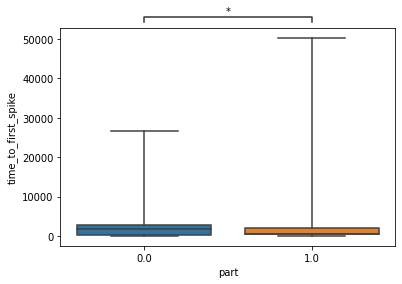

mean_isi
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:6.512e-02 t=-1.851e+00


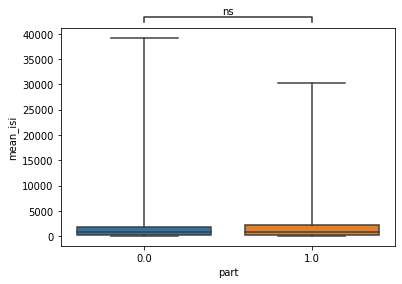

median_isi
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:1.795e-01 t=1.345e+00


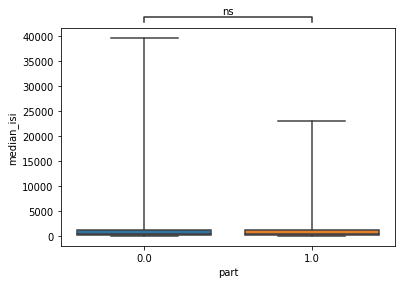

max_isi
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:8.862e-05 t=-3.973e+00


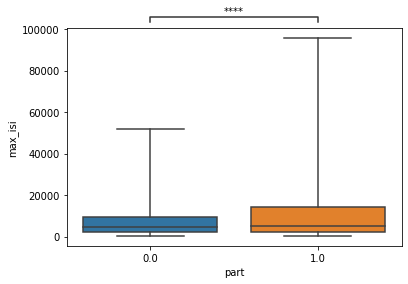

min_isi
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:1.769e-01 t=1.353e+00


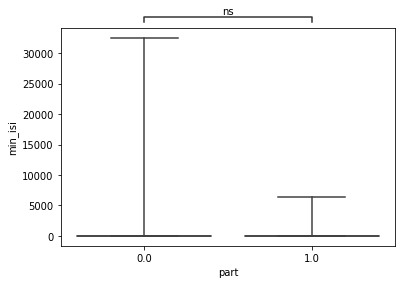

first_thr
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:1.265e-01 t=-1.532e+00


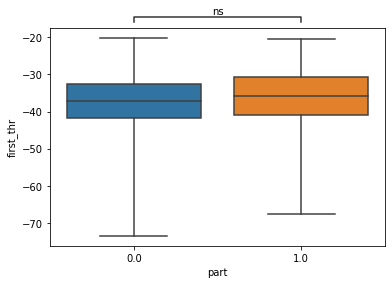

mean_thr
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:1.694e-05 t=4.372e+00


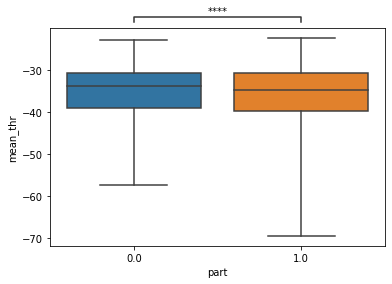

median_thr
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:8.751e-04 t=3.361e+00


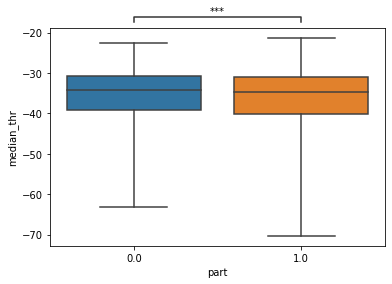

min_thr
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:1.620e-01 t=1.402e+00


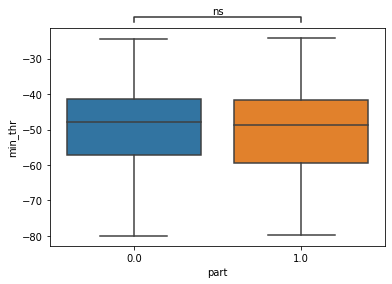

max_thr
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:2.795e-01 t=1.083e+00


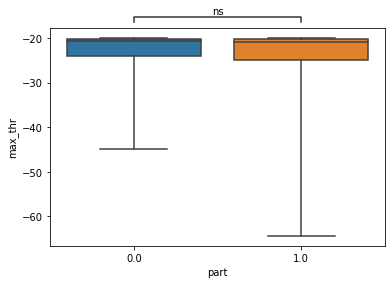

mean_width
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:8.244e-01 t=2.221e-01


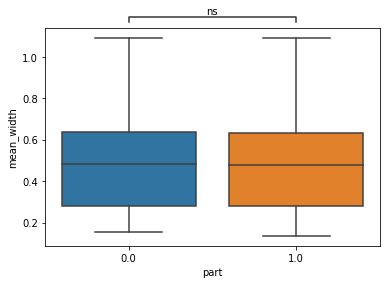

median_width
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:6.000e-01 t=5.249e-01


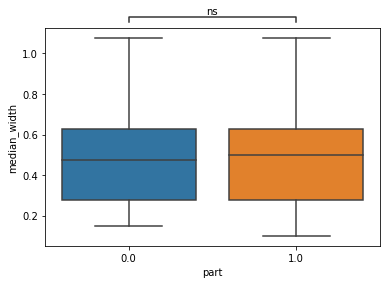

max_width
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:9.835e-02 t=1.658e+00


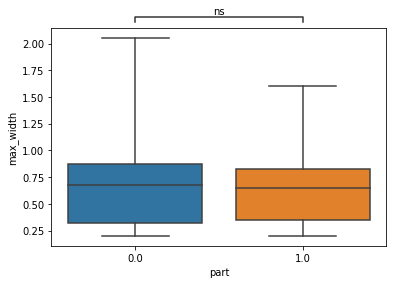

min_width
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:5.793e-01 t=-5.550e-01


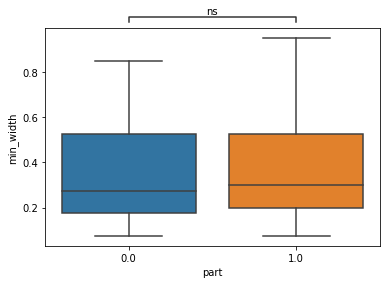

mean_amplitude
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:1.152e-02 t=2.542e+00


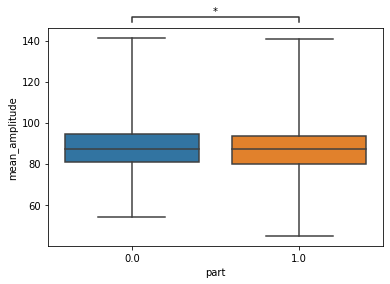

median_amplitude
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:1.943e-04 t=3.773e+00


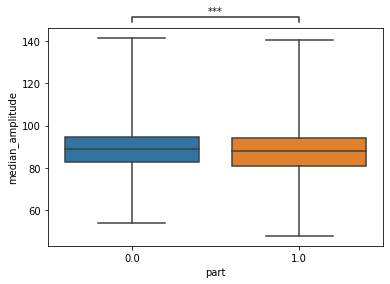

min_amplitude
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:5.554e-03 t=-2.793e+00


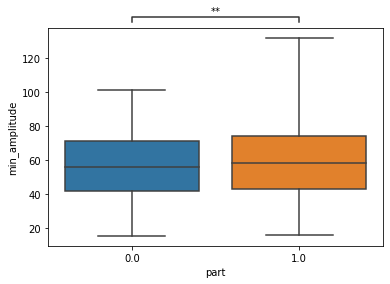

max_amplitude
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:8.040e-01 t=2.484e-01


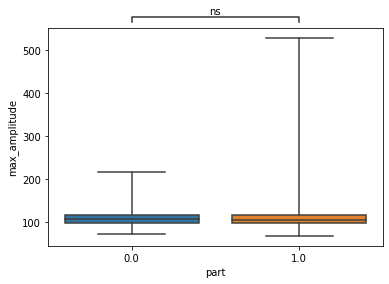

In [143]:
from statannotations.Annotator import Annotator
for i in first_half_acsf.columns[1:-4]:
    var=i
    print(var)
    all_together[var] = np.array(all_together[var],dtype=np.float32)

    order = [0,1]
    ax = sns.boxplot(data=all_together,x='part',y=var, whis=(0, 100))
    annot = Annotator(ax, [(0,1)], data=all_together, x='part', y=var, order=order)
    annot.configure(test='t-test_paired', text_format='star', loc='outside', verbose=2)
    annot.apply_test()
    ax, test_results = annot.annotate()
    plt.show()

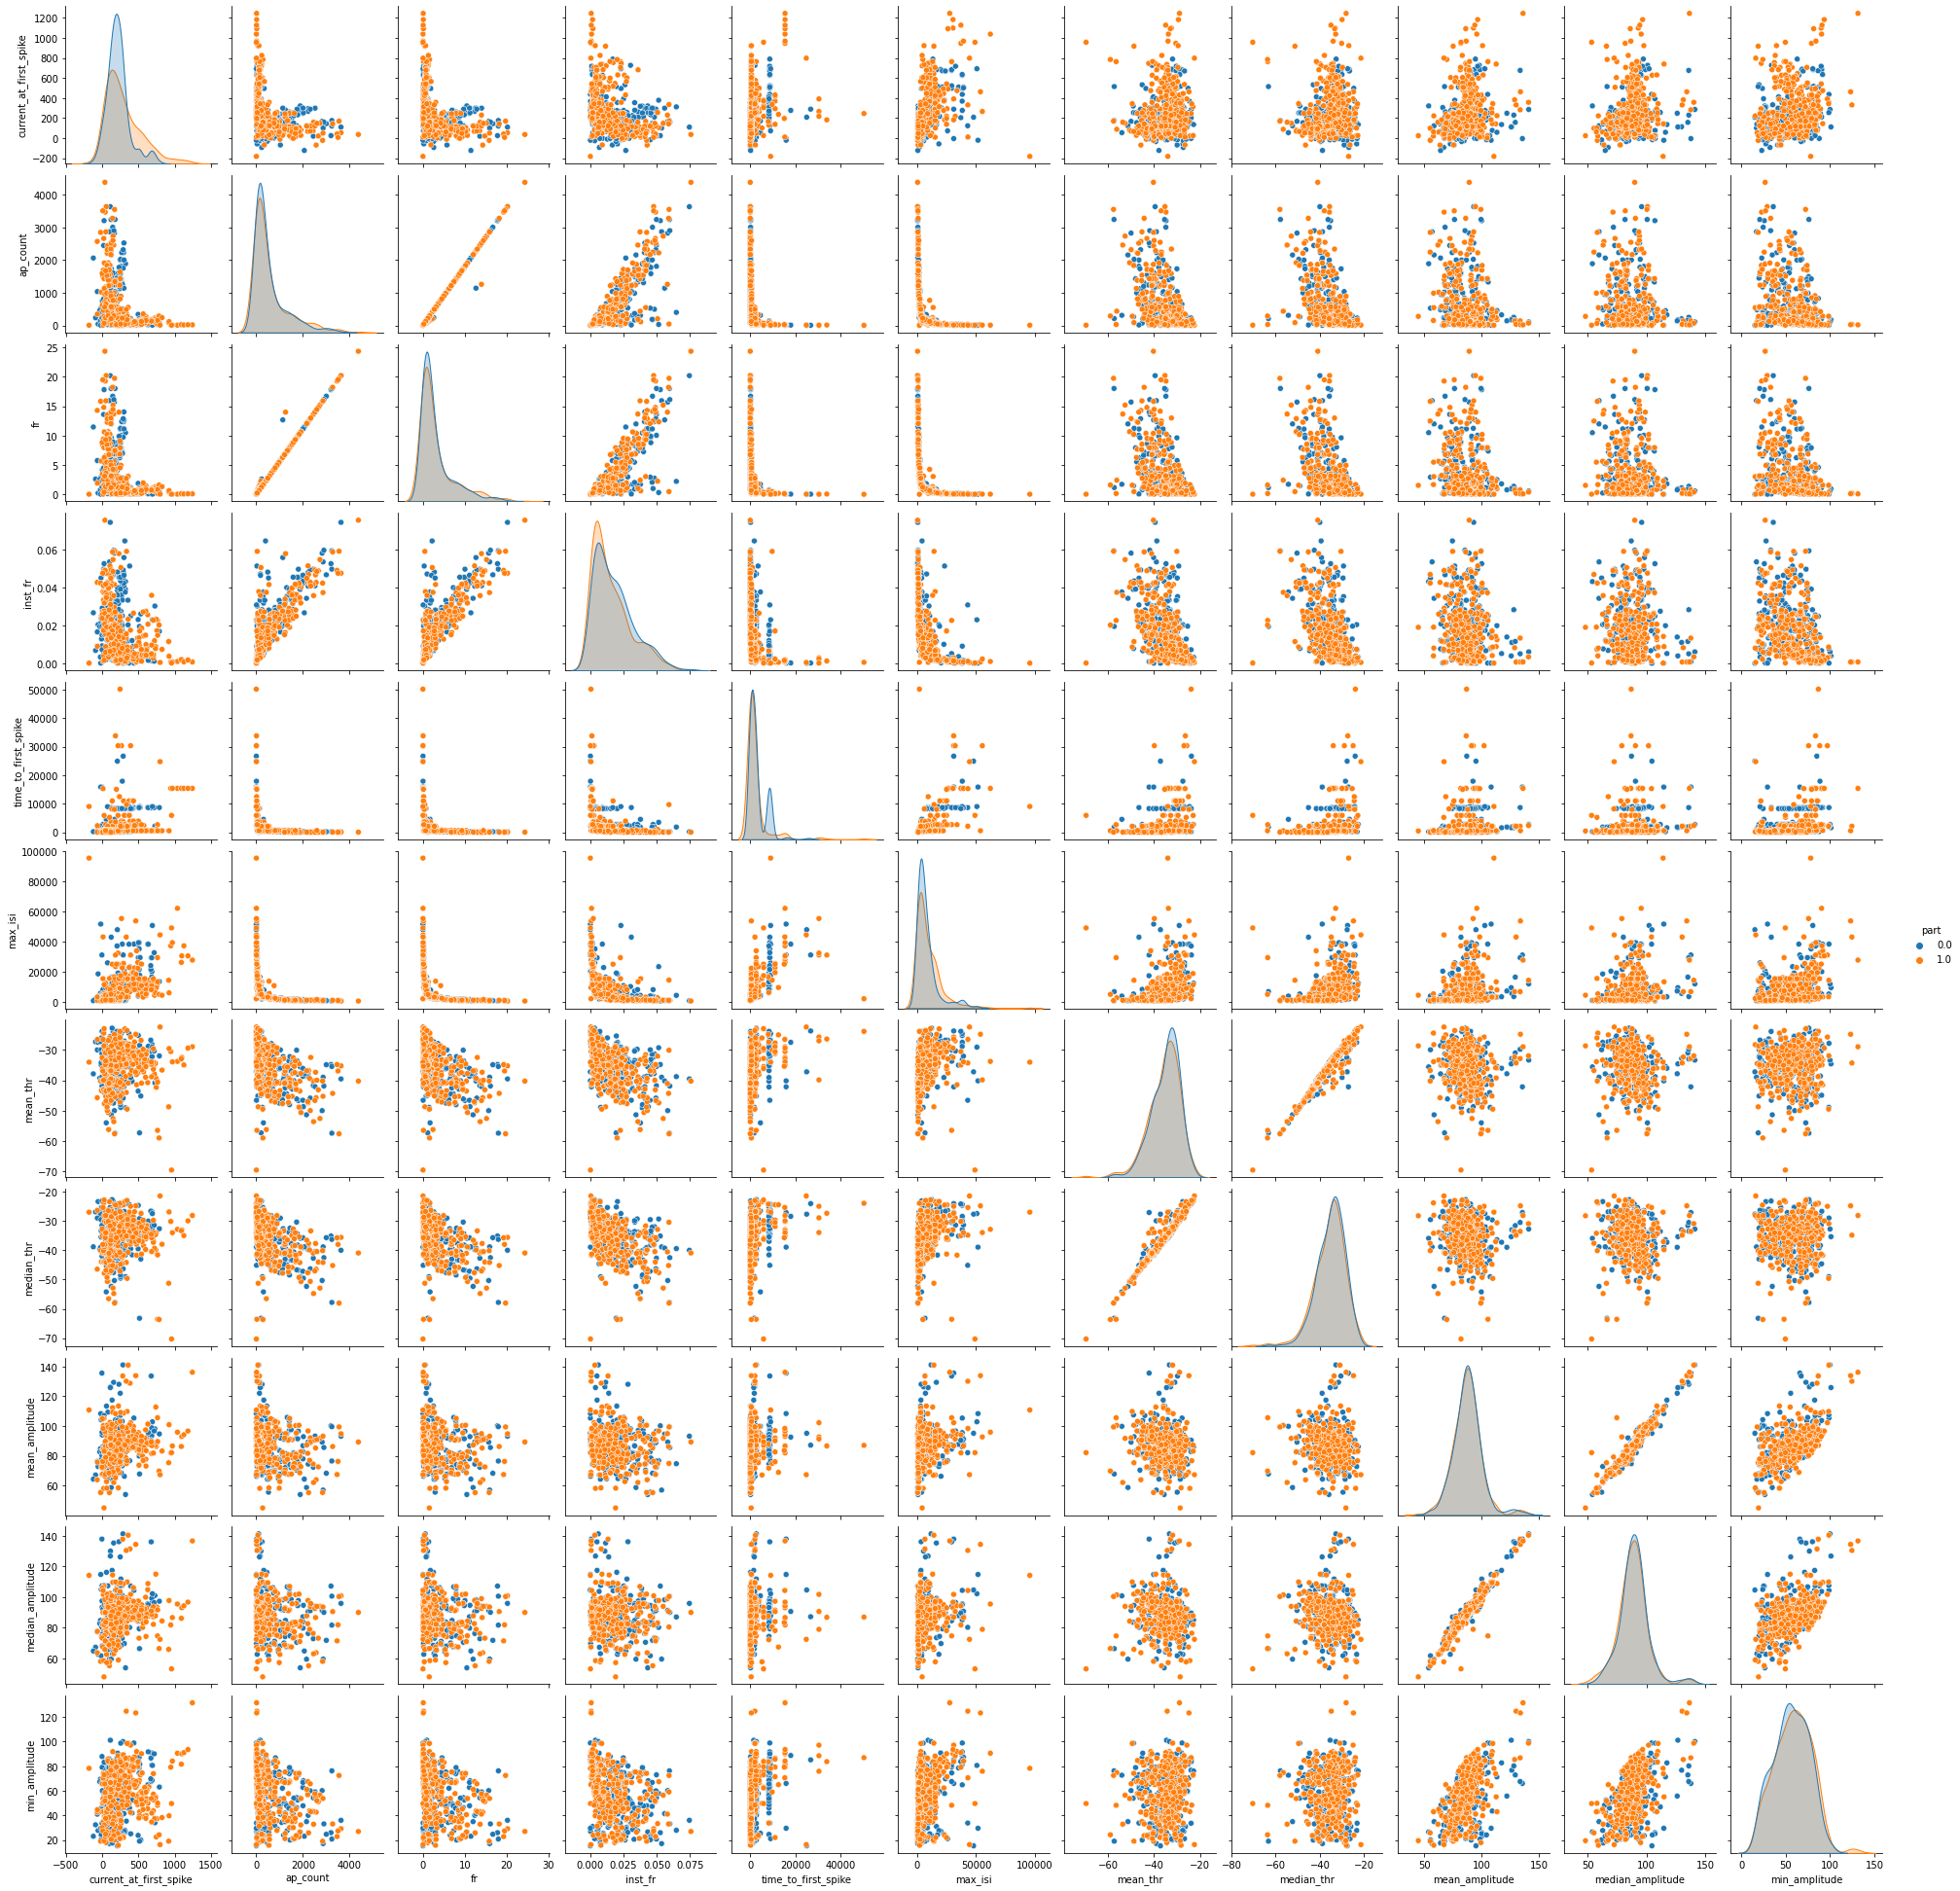

In [112]:
sig_cols = ['current_at_first_spike',
'ap_count',
'fr',
'inst_fr',
'time_to_first_spike',
'max_isi',
'mean_thr',
'median_thr',
'mean_amplitude',
'median_amplitude',
'min_amplitude',
'part']

sns.pairplot(data=all_together[sig_cols],hue='part')